In [1]:
import findspark
findspark.init("/Users/jennyzhou/Downloads/spark-2.4.5-bin-hadoop2.7")
%run data.py

# Traffic Collison Data

In [2]:
# Motor Vehicle Collisions - Crashes 1.67M rows
# get data: 2019.1.1 - today
collison_url2 = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv?$select=crash_date,borough,zip_code,collision_id&$where=crash_date>'2019-01-01T00:00:00.000'&$limit=500000"

In [3]:
collison_19to20 = pd.read_csv(collison_url2)
collison_19to20.count()

crash_date      254478
borough         165245
zip_code        165196
collision_id    254478
dtype: int64

In [4]:
collison_19to20.head(5)

,crash_date,borough,zip_code,collision_id
0,2019-01-02T00:00:00.000,NaN,NaN,4062972
1,2019-01-02T00:00:00.000,QUEENS,11370.0,4060956
2,2019-01-02T00:00:00.000,NaN,NaN,4061198
3,2019-01-02T00:00:00.000,QUEENS,11419.0,4062743
4,2019-01-02T00:00:00.000,NaN,NaN,4060821


In [5]:
collison_19to20['zip_code'].fillna(0, inplace=True)

In [6]:
#convert data type
collisonpd = collison_19to20.astype({"crash_date":'datetime64[ns]', "borough":str, "zip_code":int, "collision_id":int})

In [7]:
collison_df = spark.createDataFrame(collisonpd)

In [8]:
collison_df.count()

254478

In [9]:
collison_df.orderBy(collison_df.crash_date.desc()).show(10)

+-------------------+---------+--------+------------+
|         crash_date|  borough|zip_code|collision_id|
+-------------------+---------+--------+------------+
|2020-05-03 00:00:00|      nan|       0|     4311432|
|2020-05-03 00:00:00|   QUEENS|   11377|     4311713|
|2020-05-03 00:00:00|   QUEENS|   11434|     4311695|
|2020-05-03 00:00:00|      nan|       0|     4311417|
|2020-05-03 00:00:00|      nan|       0|     4311751|
|2020-05-03 00:00:00|MANHATTAN|   10016|     4311514|
|2020-05-03 00:00:00| BROOKLYN|   11215|     4311570|
|2020-05-03 00:00:00|      nan|       0|     4311846|
|2020-05-03 00:00:00|      nan|       0|     4311435|
|2020-05-03 00:00:00|   QUEENS|   11435|     4311562|
+-------------------+---------+--------+------------+
only showing top 10 rows



In [10]:
collison_df.createOrReplaceTempView("collisonT")

In [11]:
collison_whole = spark.sql("""
SELECT DATE(crash_date) AS crash_date,
    COUNT(*) AS num_of_crash
FROM collisonT
GROUP BY crash_date
ORDER BY crash_date
""")

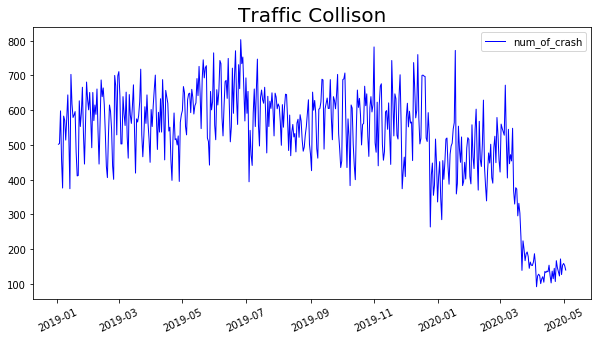

In [16]:
collison_pd = collison_whole.toPandas()
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot('crash_date','num_of_crash', data=collison_pd, marker='', color='blue', linewidth=1)
plt.title('Traffic Collison',fontsize = 20)
plt.xticks( rotation=25 )
plt.rcParams['figure.figsize'] = (15,5)
plt.legend()